In [1]:
import os, time, copy
from glob import glob
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from random import seed, shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from utils.myutils import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 设置TensorFlow的日志级别为2，只显示error和warining信息

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.get_logger().setLevel('ERROR') #删除多余的日志

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, models, Sequential，datasets
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPool2D, Concatenate
from keras.optimizers import adam_v2
import os, time, copy
from glob import glob

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten,Reshape, Dropout, BatchNormalization, Activation, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPool2D, Concatenate
from tensorflow.keras import Model,optimizers

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_path = "./data/slices60/"  # 数据路径
model_path = "./model/VGG16/"  # 设置模型保存目录
# 创建目录
for path in [model_path]:
    print(path)
    if not os.path.exists(path):
        os.makedirs(path)

./model/VGG16/


# 1.数据预处理

In [3]:
# 数据
imagePaths = glob(data_path + "*/*flag_*.npy")  # 两个目录下的所有结节文件
imagePaths = np.asarray(imagePaths)  # 转numpy
print(imagePaths[:5])
print(f"共有{len(imagePaths)}个npy文件")
# 标签
labels = [x.split("flag_")[1].split(".npy")[0] for x in imagePaths]  # 提取各文件对应的标签
# print(labels[:5])
le = LabelEncoder()  # 标签编码器
labels = le.fit_transform(labels)  # 处理标签，标签转数字
print(f"标签类别: {le.classes_}")
# labels = to_categorical(labels)  # 转one-hot编码
print(labels[:5])

['./data/slices60/pos/nID_473, ID_622, X_133, Y_259, Z_189(186-211), diam_17, flag_1.npy'
 './data/slices60/pos/nID_418, ID_548, X_115, Y_286, Z_276(259-342), diam_46, flag_1.npy'
 './data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_235(228-248), diam_15, flag_1.npy'
 './data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_245(228-248), diam_15, flag_1.npy'
 './data/slices60/pos/nID_173, ID_243, X_419, Y_413, Z_264(226-268), diam_37, flag_1.npy']
共有10863个npy文件
标签类别: ['0' '1']
[1 1 1 1 1]


In [4]:
# 打乱顺序
#seed(11)  # 设置random包的随机数种子
imageSets = list(zip(imagePaths, labels))
#shuffle(imageSets)
print(imageSets[:5])
type(imageSets)
imageSets[0][0].split(" ID_")[1].split(",")[0]


[('./data/slices60/pos/nID_473, ID_622, X_133, Y_259, Z_189(186-211), diam_17, flag_1.npy', 1), ('./data/slices60/pos/nID_418, ID_548, X_115, Y_286, Z_276(259-342), diam_46, flag_1.npy', 1), ('./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_235(228-248), diam_15, flag_1.npy', 1), ('./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_245(228-248), diam_15, flag_1.npy', 1), ('./data/slices60/pos/nID_173, ID_243, X_419, Y_413, Z_264(226-268), diam_37, flag_1.npy', 1)]


'622'

#### 对病人按6：2：2划分训练集、验证集、测试集

In [5]:
for i in range(len(imageSets)):  # 遍历每张切片提取病人ID、结节nID、结节类型标签flag
    image_path, label = imageSets[i]
    ID = int(image_path.split(" ID_")[1].split(",")[0])
    nID = int(image_path.split("ID_")[1].split(",")[0])
    flag=int(image_path.split("flag_")[1].split(".npy")[0])
    imageSets[i] = (image_path, label, ID,nID,flag)

In [6]:
df = pd.DataFrame(imageSets, columns=['image_path', 'label', 'ID','nID','flag'])# 构建新数据框df

In [7]:
IDs = df["ID"].unique().tolist()  # 提取所有病人的ID
len(IDs)
data_list = df.values.tolist()  # df转化为二维列表
data_list[:5] 

[['./data/slices60/pos/nID_473, ID_622, X_133, Y_259, Z_189(186-211), diam_17, flag_1.npy',
  1,
  622,
  473,
  1],
 ['./data/slices60/pos/nID_418, ID_548, X_115, Y_286, Z_276(259-342), diam_46, flag_1.npy',
  1,
  548,
  418,
  1],
 ['./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_235(228-248), diam_15, flag_1.npy',
  1,
  353,
  256,
  1],
 ['./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_245(228-248), diam_15, flag_1.npy',
  1,
  353,
  256,
  1],
 ['./data/slices60/pos/nID_173, ID_243, X_419, Y_413, Z_264(226-268), diam_37, flag_1.npy',
  1,
  243,
  173,
  1]]

In [9]:
# 按病人划分训练集和测试集
def psplitDF(data, col_name, reset, test_size=0.2, seed=123, shuffle=True):
    # 全部结节ID列表
    IDs = data[col_name].unique().tolist()
    # 结节ID列表划分为训练集和测试集
    train_IDs, test_IDs = train_test_split(IDs, test_size=test_size, random_state=seed, shuffle=shuffle)
    #X=len(IDs)
    #kf = KFold(n_splits=5,shuffle=False)
    #for train_index , test_index in kf.split(X):
    #    print('train_index:%s , test_index: %s ' %(train_index,test_index))
    # 得到两个数据集
    train_dat = data.loc[data[col_name].isin(train_IDs), ]  # 训练集
    test_dat = data.loc[data[col_name].isin(test_IDs),]  # 测试集
    if reset==True:  # 判断是在划分训练集和测试集，还是在划分训练集和验证集
        train_dat = train_dat.reset_index(drop=True)  # 训练集
        test_dat = test_dat.reset_index(drop=True)  # 测试集
    # 提取索引，用于模型训练
    train_index = train_dat.index.tolist()  # 训练集索引
    test_index = test_dat.index.tolist()  # 测试集索引
    # 返回训练集表、测试集表、训练集表索引、测试集表索引
    return train_dat, test_dat, train_index, test_index


In [10]:
# 按病人计算各数据子集中0-1分类占比，观察样本平衡性
def pcalRate(data, index):
    # 是否通过索引进行筛选
    if index is None:
        n = data.shape[0]
    else:
        n = len(index)
        data = data.loc[index, ]
    # 结节数量
    nn = len(data["nID"].unique())
    pp=  len(data["ID"].unique())
    rate1 = round(data["flag"].sum() / n * 100, 2)  # 计算数据子集中微乳头切片占比
    rate2 = round(data.groupby("ID")["flag"].mean().mean() * 100, 2)  # 计算数据子集中微乳头结节占比
    return f"切片数: {n}，微乳头切片占比: {rate1}%，结节数: {nn}, 微乳头结节占比：{rate2}%，病人数: {pp}"

In [11]:
train_dat, test_dat, _, test_index = psplitDF(df, "ID", test_size=0.2, reset=True)  # 按病人ID划分为训练集和测试集
train_datz, valid_dat, train_index, valid_index = psplitDF(train_dat, "ID", test_size=0.25, reset=False)  # 按病人ID将训练集再划分为训练集和验证集
print(len(train_dat["ID"].unique().tolist()))
len(train_dat)
print(f"训练数据中训练集{pcalRate(train_dat, train_index)}")
print(f"训练数据中验证集{pcalRate(valid_dat, valid_index)}")
print(f"测试数据中测试集{pcalRate(test_dat, test_index)}")

340
训练数据中训练集切片数: 6578，微乳头切片占比: 38.81%，结节数: 291, 微乳头结节占比：31.2%，病人数: 255
训练数据中验证集切片数: 2278，微乳头切片占比: 34.77%，结节数: 99, 微乳头结节占比：31.0%，病人数: 85
测试数据中测试集切片数: 2007，微乳头切片占比: 40.01%，结节数: 93, 微乳头结节占比：28.35%，病人数: 86


In [12]:
# 数据提取为列表形式
# train_dat.values.tolist() #训练集数据转化为列表
# 从训练集中提取除了前两列（image_path和label）之外的所有列的数据，将其转换为列表
trainSets=train_dat.drop(columns=df.columns[2:]).values.tolist()
# 将训练集的每一行数据转换为元组，并存储在trainSets列表中
trainSets = [tuple(data) for data in trainSets]
testSets=test_dat.drop(columns=df.columns[2:]).values.tolist()
testSets = [tuple(data) for data in testSets]
validSets=valid_dat.drop(columns=df.columns[2:]).values.tolist()
validSets = [tuple(data) for data in validSets]


In [13]:
# 将数据中的每一行数据转换为元组
for i in range(len(trainSets)):
    trainSets[i] = tuple(trainSets[i])  
type(trainSets)
for i in range(len(testSets)):
    testSets[i] = tuple(testSets[i]) 
for i in range(len(validSets)):
    validSets[i] = tuple(validSets[i]) 

In [15]:
trainSets

[('./data/slices60/pos/nID_473, ID_622, X_133, Y_259, Z_189(186-211), diam_17, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_418, ID_548, X_115, Y_286, Z_276(259-342), diam_46, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_235(228-248), diam_15, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_256, ID_353, X_112, Y_271, Z_245(228-248), diam_15, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_173, ID_243, X_419, Y_413, Z_264(226-268), diam_37, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_11, ID_27, X_364, Y_276, Z_110(103-126), diam_12, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_193, ID_272, X_333, Y_157, Z_110(105-142), diam_19, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_481, ID_632, X_293, Y_291, Z_27(15-28), diam_13, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_319, ID_429, X_310, Y_324, Z_220(202-238), diam_29, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_52, ID_90, X_205, Y_246, Z_132(131-174), diam_28, flag_1.npy',
  1),
 ('./data/slices60/pos/nID_

In [16]:
trainset =trainSets+ validSets #将训练集验证集合并

'1'

#### 构建训练集y_train、测试集y_test和验证集y_valid的标签

In [17]:
#构建0-1y
y_train=[]
y_test=[]
y_valid=[]
for i in range(6578):
    file_path = trainSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])#提取文件路径中的标签(0或1)并将其附加到列表 y_train
    y_train.append(c)
    
for i in range(2007):
    file_path = testSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_test.append(c)
    
for i in range(2278):
    file_path = validSets[i][0]  # 获取文件路径
    c = int(file_path.split('flag_')[1].split(".")[0])
    y_valid.append(c)  

#print(y_test)
type(y_test)
y_train=np.array(y_train)
type(y_train)
y_test=np.array(y_test)
type(y_test)
y_test.shape
type(y_valid)
y_valid=np.array(y_valid)
y_valid.shape

(2278,)

In [18]:
y_train.shape
y_train=list(y_train)
y_train=np.array(y_train)
y_train.resize((6578, 1))#调整y_train数组的形状为(6578, 1)
print(y_train)
y_test=list(y_test)
y_test=np.array(y_test)
y_test.resize((2007, 1))#调整y_test数组的形状为(2007, 1)
y_valid=list(y_valid)
y_valid=np.array(y_valid)
y_valid.resize((2278, 1))#调整y_valid数组的形状为(2278, 1)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


(6578, 1)

In [21]:
#计算训练集中微乳头切片的数量
count=0
for i in range(6578):
    if y_train[i]==1:
        count=count+1
print(count)

2553


In [22]:
#计算验证集中微乳头切片的数量
count=0
for i in range(2278):
    if y_valid[i]==1:
        count=count+1
print(count)

792


In [23]:
#计算测试集中微乳头切片的数量
count1=0
for i in range(6578):
    if y_train[i]==1:
        count=count+1
print(count)

3345


#### 数据预处理（单通道转RGB三通道）

In [24]:
# 读取单个npy文件
def get_data_from_file(filePath):
    img_gray = np.load(filePath)  # 读取npy，[60,60]
    img_rgb = gray2rgb(img_gray)  # 第一种办法，灰度图转RGB，[60,60,3]
    #img_rgb = np.repeat(img_gray[..., np.newaxis], 1, -1)  # 第二种办法，单通道复制为3通道，[60,60,3]
    #print(tes_image[0].shape)
    #img_rgb=tf.image.resize(img_rgb, [32,32])
    #print(resized)
    return img_rgb

# 遍历列表，读取多个npy文件，组合成一个batch
def combineBatch(paths):
    batch_data = []
    for path in paths:
        batch_data.append(get_data_from_file(path))
    return np.asarray(batch_data)  # [B,H,W,C]

In [25]:
#从训练集、测试集和验证集的信息中提取出每个样本的文件路径
train_paths = [item[0] for item in trainSets]
len(train_paths)
test_paths = [item[0] for item in testSets]
len(train_paths)
valid_paths = [item[0] for item in validSets]
len(valid_paths)

2278

#### 将切片数据分batch输入模型，得到各切片的featuremap，最后可以构成特征矩阵

In [26]:
#训练
features1 = []
batchsize = 50  # 每个batch的数据量
N = len(trainSets)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = train_paths[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features1.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features1.append(batchData)  # 存储featuremap
features1 = np.vstack(features1)

features1.shape

100%|██████████| 131/131 [01:30<00:00,  1.45it/s]


(6578, 60, 60, 3)

In [27]:
#测试
features2 = []
batchsize = 50  # 每个batch的数据量
N = len(testSets)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = test_paths[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features2.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features2.append(batchData)  # 存储featuremap
features2 = np.vstack(features2)

features2.shape

100%|██████████| 40/40 [00:23<00:00,  1.72it/s]


(2007, 60, 60, 3)

In [28]:
#验证
features3 = []
batchsize = 50  # 每个batch的数据量
N = len(validSets)  # 样本总数
batchs = N // batchsize  # 分多少个batch计算
for ibatch in trange(batchs):  # 遍历每个整数batch
    batchPaths = valid_paths[ibatch * batchsize: (ibatch+1) * batchsize]  # 数据路径切片
    batchData = combineBatch(batchPaths)  # 组合batch数据
    features3.append(batchData)
batchPaths = imagePaths[(ibatch+1) * batchsize: N]  # 数据路径切片
batchData = combineBatch(batchPaths)  # 组合batch数据
features3.append(batchData)  # 存储featuremap
features3 = np.vstack(features3)

features3.shape

100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


(2278, 60, 60, 3)

# 2.ResNet模型构建

In [29]:
#定义卷积层
def ConvCall(x,filtten,xx,yy,strides = (1,1)):
    x = layers.Conv2D(filtten,(xx,yy),strides=strides,padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x
#定义ResNet基本块
def ResNetblock(input,filtten,strides = (1,1)):
    x = ConvCall(input,filtten,3,3,strides=strides)
    x = layers.Activation("relu")(x)
 
    x = ConvCall(x,filtten,3,3,strides=(1,1))
    if strides != (1,1):
        residual = ConvCall(input,filtten,1,1,strides=strides)
    else:
        residual = input
 
    x = x + residual
    x = layers.Activation("relu")(x)
 
    return x
 
def ResNet18(inputs):
    x = ConvCall(inputs, 64, 3, 3, strides=(1, 1))
    x = layers.Activation('relu')(x)
 
    x = ResNetblock(x, 64, strides=(1, 1))
    x = ResNetblock(x, 64, strides=(1, 1))
 
    x = ResNetblock(x, 128, strides=(2, 2))
    x = ResNetblock(x, 128, strides=(1, 1))
 
    x = ResNetblock(x, 256, strides=(2, 2))
    x = ResNetblock(x, 256, strides=(1, 1))
 
    x = ResNetblock(x, 512, strides=(2, 2))
    x = ResNetblock(x, 512, strides=(1, 1))
    x = layers.GlobalAveragePooling2D()(x)  # 全局平均池化
    x=layers.Dropout(0.3)(x)

    output = layers.Dense(1, "sigmoid")(x)
    return output
 

In [30]:
inputs = keras.Input((60,60,3))
 
output = ResNet18(inputs)
 
model = models.Model(inputs,output)
 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 60, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 60, 60, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 60, 60, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### 模型编译与训练

In [31]:

# 记录训练开始时间，同时作为保存模型文件名的前缀
train_start = time.strftime("%Y-%m-%d %H:%M:%S")
# 初始学习率为0.001，如果20个epoch后精度没有提升，学习率降低0.5；存外样本精度最高的模型
model_file = os.path.join(model_path, f'{train_start} res_bestres.h5')
logging_file = os.path.join(model_path, f"{train_start} res_metricres.csv")
callback = get_callbacks(model_file, initial_learning_rate=0.1, learning_rate_drop=0.1, learning_rate_epochs=None,
                  learning_rate_patience=20, logging_file=logging_file, verbosity=1,
                  early_stopping_patience=10,tensorboard_callback = None)
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
# 训练模型
model.fit(features1, y_train, epochs=50, callbacks=callback, validation_data=(features3, y_valid), 
            workers=16, use_multiprocessing=True)
#cbamuse_multiprocessing=True

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Train on 6578 samples, validate on 2278 samples
Epoch 1/50
6578/6578 [==============================] - ETA: 0s - loss: 0.6651 - binary_accuracy: 0.6843

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


6578/6578 [==============================] - 23s 4ms/sample - loss: 0.6651 - binary_accuracy: 0.6843 - val_loss: 2.1826 - val_binary_accuracy: 0.6523 - lr: 0.0010
Epoch 2/50
6578/6578 [==============================] - 15s 2ms/sample - loss: 0.5554 - binary_accuracy: 0.7370 - val_loss: 0.9299 - val_binary_accuracy: 0.6523 - lr: 0.0010
Epoch 3/50
6578/6578 [==============================] - 16s 2ms/sample - loss: 0.4934 - binary_accuracy: 0.7735 - val_loss: 0.7389 - val_binary_accuracy: 0.6102 - lr: 0.0010
Epoch 4/50
6578/6578 [==============================] - 19s 3ms/sample - loss: 0.4500 - binary_accuracy: 0.7995 - val_loss: 0.6937 - val_binary_accuracy: 0.6835 - lr: 0.0010
Epoch 5/50
6578/6578 [==============================] - 16s 2ms/sample - loss: 0.4013 - binary_accuracy: 0.8262 - val_loss: 1.0932 - val_binary_accuracy: 0.6826 - lr: 0.0010
Epoch 6/50
6578/6578 [==============================] - 16s 2ms/sample - loss: 0.3503 - binary_accuracy: 0.8527 - val_loss: 1.4455 - val_bina

#### 模型预测

In [32]:
result=model.predict(features2) #对测试集进行预测
#pred = tf.argmax(result, axis=1)
print(result)

[[9.7991115e-01]
 [2.0673618e-01]
 [9.9999976e-01]
 ...
 [9.2142139e-04]
 [5.1015796e-04]
 [9.9999881e-01]]


In [33]:
#计算阈值，将预测结果转换为0或1
result.max()
result.min()
result.shape
a=result.min()+(result.max()-result.min())/2
result1=result.tolist() # 将预测结果转换为列表
type(result.tolist())
pred1={}
for i in range(2007):
    if result1[i]<=a:
        pred1[i]=0
    else:
        pred1[i]=1

(2007, 1)

In [37]:
#统计预测结果为1（微乳头）的数量
count=0
for i in range(2007):
    if pred1[i]==1:
        count=count+1
print(count)

695


In [40]:
# 提取预测结果
#pred1=pred1.numpy()
pred1 = pred1.items()
# Convert object to a list
pred1= list(pred1) 
# Convert list to an array
pred1 = np.array(pred1) 
# print the numpy array
print(type(pred1))
#type(y_test)
print(type(result))
pred=pred1[:,1]
pred

<class 'numpy.ndarray'>


array([1, 0, 1, ..., 0, 0, 1])

# 3.模型评估

Confusion matrix, without normalization
[[977 227]
 [335 468]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.71998,0.811462,0.582814,0.673381,0.744665,0.624833,0.71998,0.775379


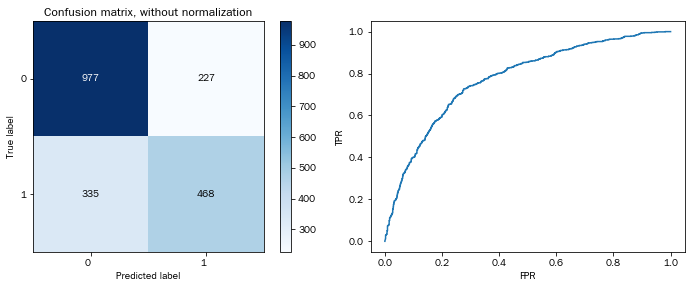

In [41]:
#切片层面
#切片层面
labels_value = np.array([0, 1])
tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(y_test, pred)
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(y_test, pred) ##结果是类别1的score
acc2 = accuracy_score(y_test, pred)
    # ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, result[:])
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
cm = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(y_test, pred)]
print('Confusion matrix, without normalization')
print(cm)

#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    
    # 整合评估指标
metrics_s = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
    
fig.tight_layout()
metrics_s

In [42]:
#计算结节层面的预测结果
pthresh=0.5
if test_index is None:
    noduleData = test_dat.loc[:, ["nID", "ID", "flag"]].copy()  # copy测试集原数据
else:
    noduleData = test_dat.loc[test_index, ["nID", "ID", "flag"]].copy()  # copy测试集原数据
noduleData["y_pred"] = pred
noduleData["0_value"] = result
noduleData = noduleData.groupby("nID").mean()  # 平均法
noduleData[["ID","flag"]] = noduleData[["ID", "flag"]].astype(int)  # 保持数据类型
noduleData["voting_pred"] = noduleData["y_pred"].apply(lambda x: 1 if x > pthresh else 0)  # 投票法得到预测标签，90%阈值
#compreEval(noduleData["flag"], noduleData["voting_pred"], np.asarray(noduleData["0_value"]), classes=labels_value, normalize=False)

Confusion matrix, without normalization
[[57 10]
 [12 14]]


,ACC_pred,Specificity,Sensitivity,PPV,NPV,F1-Score,ACC_argmax,AUC
0,0.763441,0.850746,0.538462,0.583333,0.826087,0.56,0.763441,0.773823


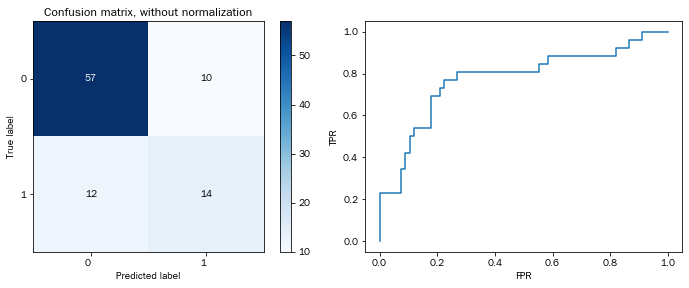

In [43]:
# 结节层面
tn, fp, fn, tp = confusion_matrix(noduleData["flag"], noduleData["voting_pred"], labels=labels_value).ravel() ##ravel数组维度拉成一维数组
    # Accuracy
acc1 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
#     print("Accuracy:{:.4f}".format(acc1))
    # 特异性：TN / N
specificity = tn / (tn+fp)
    # 敏感度：TP / P
sensitivity= tp/(tp+fn)
    # Positive predictive value PPV = TP / (TP + FP)
ppv = tp / (tp+fp)
    # Negative predictive value NPV = TN / (TN + FN)
npv = tn / (tn+fn)
    # F1-score
f1 = f1_score(noduleData["flag"], noduleData["voting_pred"]) ##结果是类别1的score
acc2 = accuracy_score(noduleData["flag"], noduleData["voting_pred"])
    # ROC曲线
fpr, tpr, thresholds = roc_curve(noduleData["flag"], np.asarray(noduleData["0_value"]))
roc_auc = auc(fpr, tpr)
    # 最佳阈值
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
bestThresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] ##argsort数组中的元素从小到大排序后的索引数组值
title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
cm = confusion_matrix(noduleData["flag"], noduleData["voting_pred"])
    # Only use the labels that appear in the data
classes = labels_value[unique_labels(noduleData["flag"], noduleData["voting_pred"])]
print('Confusion matrix, without normalization')
print(cm)
#     fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
        xticklabels=classes, yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')
ax.set_ylim(len(classes)-0.5, -0.5)
    # Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")  
    # Loop over data dimensions and create text annotations.
fmt = 'd' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
    # 绘制ROC曲线
ax = fig.add_subplot(122)
ax.plot(fpr, tpr, label='ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
    # 整合评估指标
metrics_n = pd.DataFrame({"ACC_pred": [acc1], "Specificity": [specificity], "Sensitivity": [sensitivity],
                            "PPV": [ppv], "NPV": [npv], "F1-Score": [f1], "ACC_argmax": [acc2], "AUC": [roc_auc]})
fig.tight_layout()
metrics_n
